In [81]:
# Notebook created solely for the final report based off the prototype and presentation ones.
import polars as pl
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

# FRIENDLY NAMES:
FRIENDLY_NAMES = {
    "C": "C",
    "CXX": "C++",
    "RUST": "Safe Rust",
    "RUST_OOB": "No Out-of-Bounds",
    "RUST_RPTR": "Raw Pointers",
}

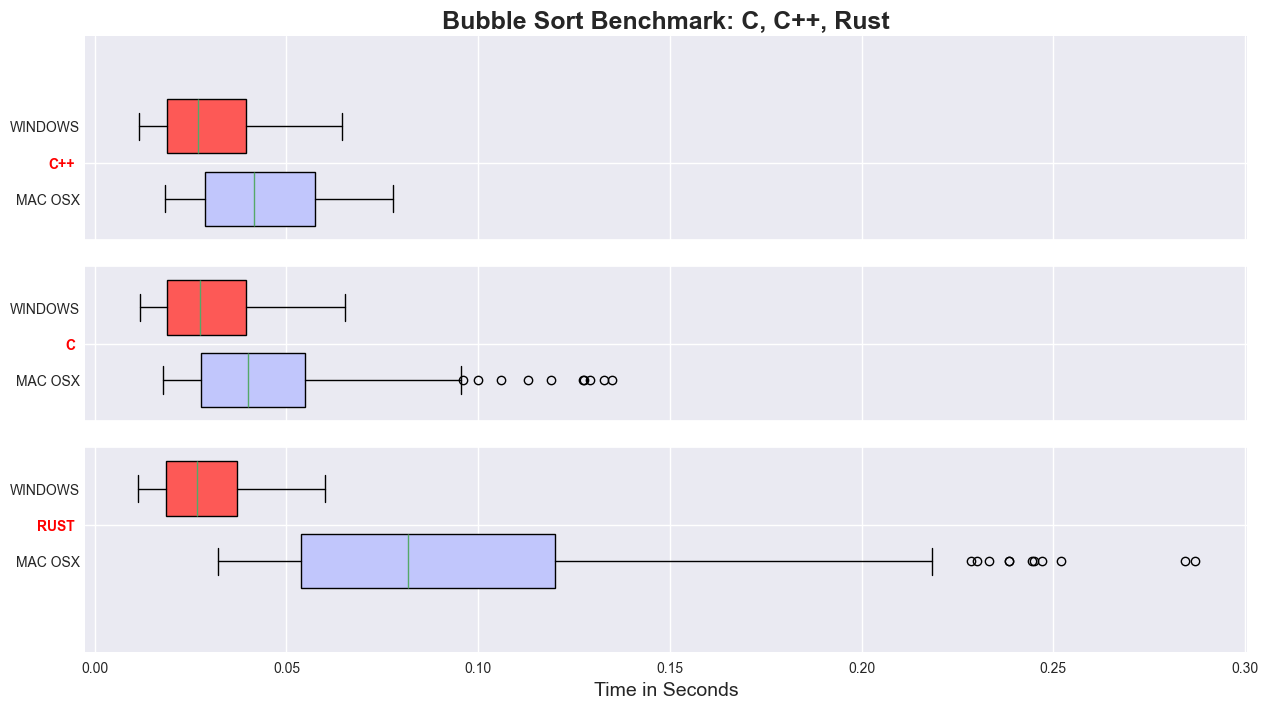

In [10]:
# GRAPH A: A Direct Benchmark Between Rust, C, and C++ (FINAL)
df_win32 = pl.read_parquet("bubble-win32.parquet").select(["RUST", "C", "CXX"])
df_osx = pl.read_parquet("bubble-darwin.parquet").select(["RUST", "C", "CXX"])

fig, ax = plt.subplots(figsize=(15, 8))

# In hindsight, the language should've been its own column to make it easier for mpl to graph.
WIN_POS_START_DELTA = [0.2, 1.0]
OSX_POS_START_DELTA = [-0.2, 1.0]
BAR_WIDTH = 0.3

for i, column in enumerate(df_win32.columns):
    win_plot = ax.boxplot(df_win32.select(pl.col(column)), orientation="horizontal", patch_artist=True,
               label=[column], positions=[WIN_POS_START_DELTA[0] + WIN_POS_START_DELTA[1] * i], widths=[BAR_WIDTH])
    for box in win_plot["boxes"]:
        box.set_facecolor("xkcd:grapefruit")
for i, column in enumerate(df_osx.columns):
    osx_plot = ax.boxplot(df_osx.select(pl.col(column)), orientation="horizontal", patch_artist=True,
           label=[column], positions=[OSX_POS_START_DELTA[0] + OSX_POS_START_DELTA[1] * i], widths=[BAR_WIDTH])

    for box in osx_plot["boxes"]:
        box.set_facecolor("xkcd:light periwinkle")

ax.axhline(y=0.5, color="white", lw=20)
ax.axhline(y=1.5, color="white", lw=20)

ax.set_yticks([0.2, -0.2, 1.2, 0.8, 2.2, 1.8], minor=True)
ax.set_yticklabels(["WINDOWS", "MAC OSX", "WINDOWS", "MAC OSX", "WINDOWS", "MAC OSX"],
                   minor=True, fontweight="bold", fontsize=12)
ax.set_yticks(range(3))
ax.set_yticklabels(["RUST", "C", "C++"], fontsize=10, color="red", fontweight="bold");
ax.set_title("Bubble Sort Benchmark: C, C++, Rust", fontsize=18, fontweight="bold")
ax.set_xlabel("Time in Seconds", fontsize=14);

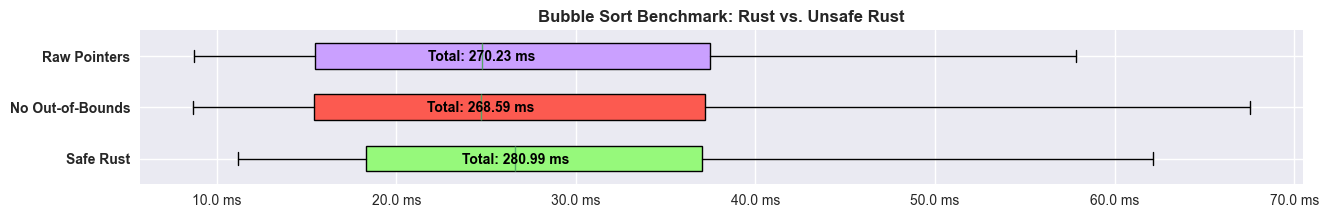

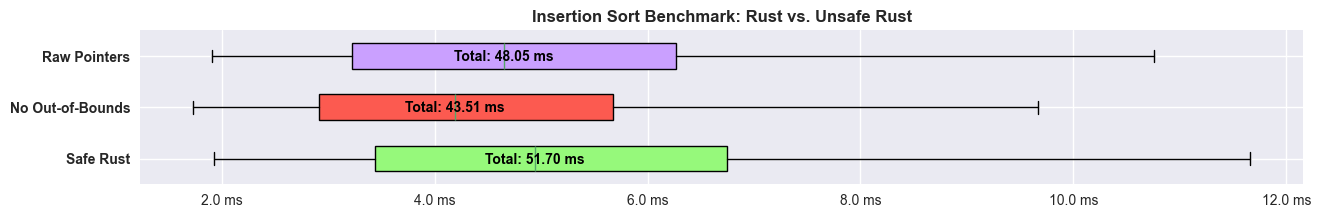

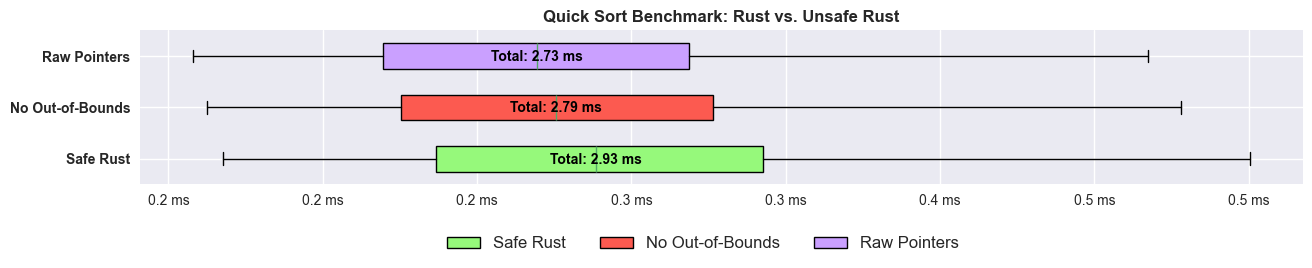

In [94]:
# GRAPH 2: Benchmarking Unsafe vs Safe Rust -- Bubble, Insertion, and Quick Sort. (Low, Mid, High)
from matplotlib.ticker import FuncFormatter

# RUST, RUST_OOB, RUST_RAW
HEADERS = ["RUST", "RUST_OOB", "RUST_RPTR"]
SORT_TYPES = ["Bubble", "Insertion", "Quick"]

# WINDOWS:
win_us_dfs = [
    pl.read_parquet("bubble-win32_wu.parquet").select(pl.col(HEADERS)),
    pl.read_parquet("insertion-win32_wu.parquet").select(pl.col(HEADERS)),
    pl.read_parquet("quick-win32_wu.parquet").select(pl.col(HEADERS)),
]


BAR_WIDTH = 0.5

def format_time(x, pos, _ax):
    # Seconds -> MS
    x *= 1000
    return f'{x:.1f} ms'

y = 0
for i,df in enumerate(win_us_dfs):
    fig, ax = plt.subplots(figsize=(15, 2))
    for j, column in enumerate(df.columns):
        plot = ax.boxplot(df.select(pl.col(column)), orientation="horizontal", patch_artist=True,
                          label=[FRIENDLY_NAMES[column]], positions=[y], widths=[BAR_WIDTH], showfliers=False)
        total = ax.annotate("Total: %.2f ms" % (df[column].sum()), xy=(df[column].median(), y-0.1), fontweight="bold", color="black")
        total.set_horizontalalignment("center")
        for box in plot["boxes"]:
            box.set_facecolor(["xkcd:light green", "xkcd:coral", "xkcd:pastel purple"][j])
        y += 1
    ax.set_yticklabels([FRIENDLY_NAMES[col] for col in HEADERS], fontweight="bold")
    ax.set_title(f"{SORT_TYPES[i]} Sort Benchmark: Rust vs. Unsafe Rust", fontweight="bold")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, y, ax=ax : format_time(x, y, ax)))
    
    if i == 2:
        fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3, fontsize="large")

In [48]:
# GRAPH 3: SISD vs SIMD (FINAL)
df_sisd = pl.read_parquet("elementary_ops_sisd.parquet")
df_simd = pl.read_parquet("elementary_ops_simd.parquet")

Text(0.5, 1.0, 'Rust SISD vs SIMD Instructions Benchmark')

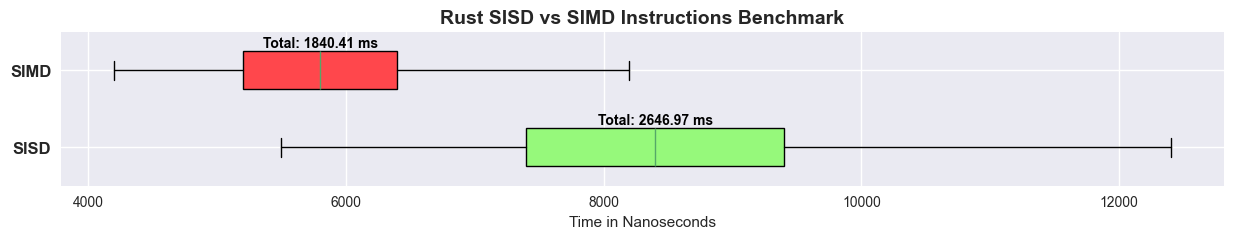

In [47]:
# GRAPH 3: SISD vs SIMD (FINAL)
fig, ax = plt.subplots(figsize=(15, 2))

# SISD:
win_plot_sisd_df = df_sisd["TIME_NS"]
win_plot = ax.boxplot(
    x=win_plot_sisd_df, positions=[1],
    orientation="horizontal", patch_artist=True, showfliers=0, widths=[0.5])
for box in win_plot["boxes"]:
    box.set_facecolor("xkcd:light green")

sisd_total = ax.annotate("Total: %.2f ms" % (win_plot_sisd_df.sum() / 1e+6), xy=(win_plot_sisd_df.median(), 1.3), fontweight="bold", color="black")
sisd_total.set_horizontalalignment("center")

# SIMD:
win_plot_simd_df = df_simd["TIME_NS"]
win_plot = ax.boxplot(
    x=win_plot_simd_df, positions=[2],
    orientation="horizontal", patch_artist=True, showfliers=0, widths=[0.5])
for box in win_plot["boxes"]:
    box.set_facecolor("xkcd:light red")
simd_total = ax.annotate("Total: %.2f ms" % (win_plot_simd_df.sum() / 1e+6), xy=(win_plot_simd_df.median(), 2.3), fontweight="bold", color="black")
simd_total.set_horizontalalignment("center")

ax.set_yticks([1, 2])
ax.set_yticklabels(["SISD", "SIMD"], fontweight="bold", fontsize=12)
ax.set_xlabel("Time in Nanoseconds");
ax.set_title("Rust SISD vs SIMD Instructions Benchmark", fontsize=14, fontweight="bold")